In [1]:
# Import packages

import pandas as pd

import numpy as np
import _pickle as cpickle
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '/home/ec2-user/SageMaker/mymodule/')

from common_functions import psi
from common_functions import ks
import boto3


%matplotlib inline

In [2]:
bucket_name = 'mf-ml-ds'
# s3_source = 's3://'+ bucket_name +'/propensity_to_fund/model_monitor/val_'
# s3_source_path  = s3_source + YYYYMM
# s3_score_target  = 'propensity_to_fund/model_monitor/val_' + YYYYMM +'/'
# # pps_score_file_name = 'xgb_weighted_score_pot_' + YYYYMM +'.csv'

# psi_file_path = 's3://'+ bucket_name + '/' + s3_score_target
model_path = 'propensity_to_pay/final_model/'

s3 = boto3.resource('s3')

In [3]:
def upload_model(model, model_name):
    with open(model_name, 'wb') as f:
        cpickle.dump(model, f)
    s3.meta.client.upload_file(model_name, bucket_name, model_path + model_name)

In [17]:
#read in the csv model development data
df=pd.read_csv('s3://mf-ml-ds/propensity_to_pay/Monthly_Validation/val_202008/slows.csv')

df.columns


Index(['RefreshFicoScore', 'Original_Term', 'LNAPRO', 'number_of_prior_loans',
       'DISPOSABLE_INCOME', 'yrs_on_job_dbl', '__of_days_until_pmt_date',
       'MaxCarValue', 'Times29_Ever', 'Times30_Ever', 'Times90_Ever',
       'ADA_3236', 'ADA_3117', 'ADA_3113', 'ADA_3124', 'ADA_3756', 'ADA_3854',
       'ADA_3122', 'ADA_3135', 'ADA_3159', 'ADA_3268', 'ADA_3415', 'ADA_3743',
       'ADA_3755', 'ADA_3798', 'ADA_3805', 'ADA_3843', 'ADA_3206', 'ADA_3293',
       'ADA_3761', 'ADA_3835', 'ADA_3024', 'ADA_3027', 'ADA_3031', 'ADA_3580',
       'ADA_3723', 'ADA_3395', 'ADA_3724', 'ADA_3758', 'ADA_3166', 'badflag',
       'Homeowner', 'FPD_n', 'Auto_Pay_flag', 'PB', 'Coborrower', 'acflnps_n',
       'lendingtree', 'CreditKumar', 'upb_ratio'],
      dtype='object')

In [5]:
df.shape

(517057, 50)

In [6]:
df['badflag'].value_counts(normalize=True)

0.0    0.953953
1.0    0.046047
Name: badflag, dtype: float64

In [15]:
df.groupby('Coborrower')['badflag'].mean()

Coborrower
0    0.046087
1    0.045713
Name: badflag, dtype: float64

In [8]:

import scorecardpy as sc
#filter variable via missing rate, iv, identcal value rate
# dt_s=sc.var_filter(df, y='fund_flag', iv_limit=0.01,missing_limit = 0.95, identical_limit = 0.95)

bins=sc.woebin(df, y="badflag", save_breaks_list='break_list')

[INFO] creating woe binning ...


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scorecardpy/condition_fun.py:96: UserWarning: There are NaNs in 'badflag' column. The rows with NaN in 'badflag' were removed from dat.
  warnings.warn("There are NaNs in \'{}\' column. The rows with NaN in \'{}\' were removed from dat.".format(y,y))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Binning on 517038 rows and 50 columns in 00:01:26
[INFO] The breaks_list is saved as break_list_20220218_161036.py


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scorecardpy/woebin.py:1203: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scorecardpy/woebin.py:1203: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scorecardpy/woebin.py:1203: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figu

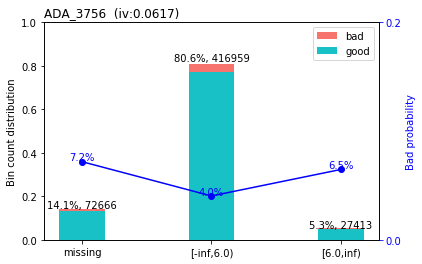

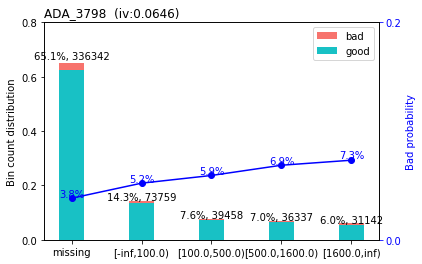

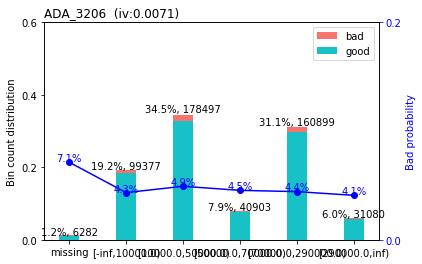

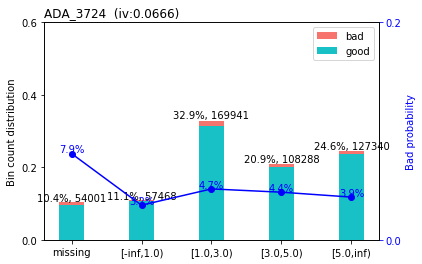

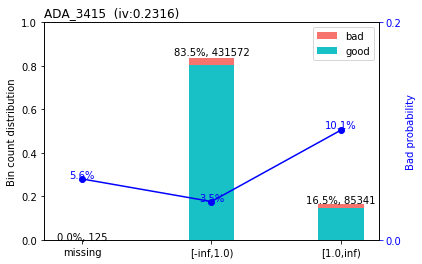

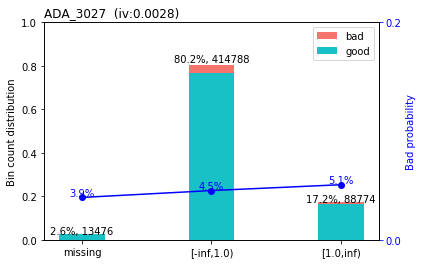

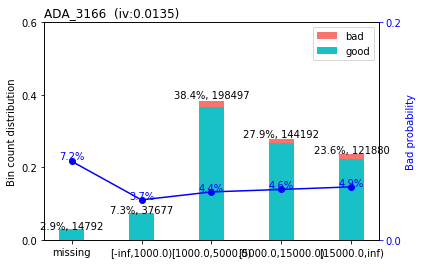

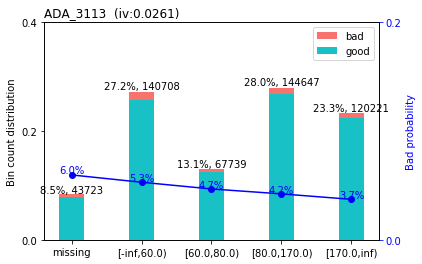

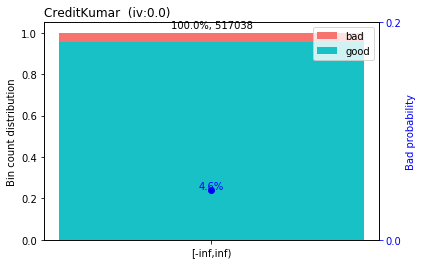

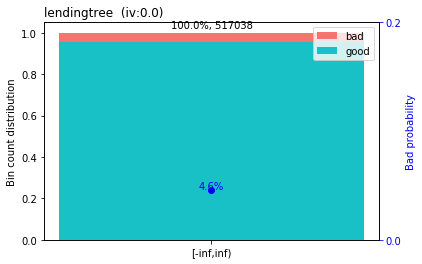

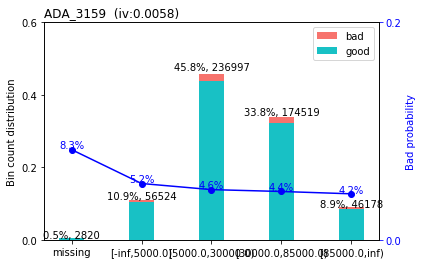

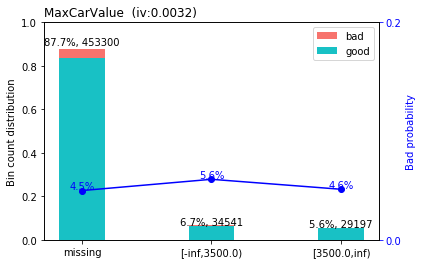

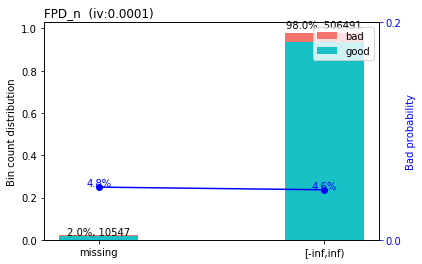

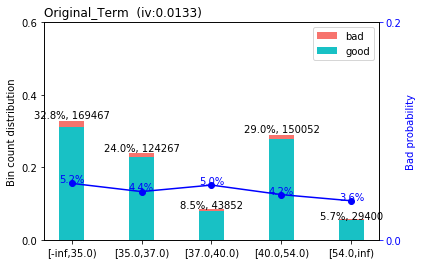

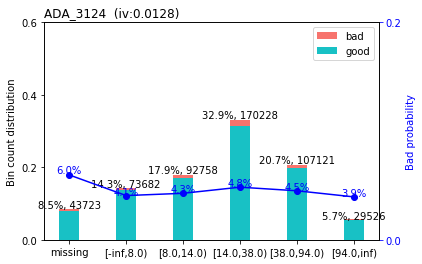

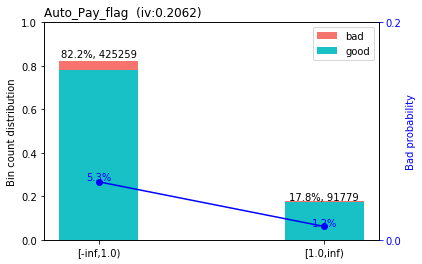

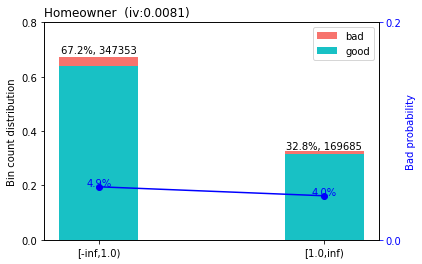

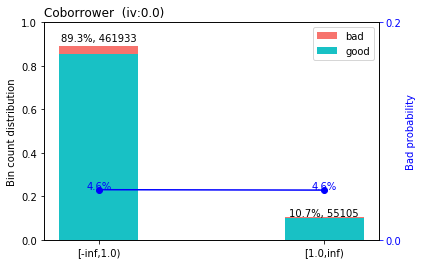

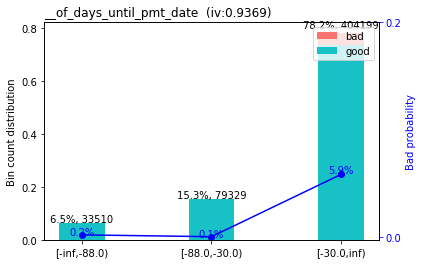

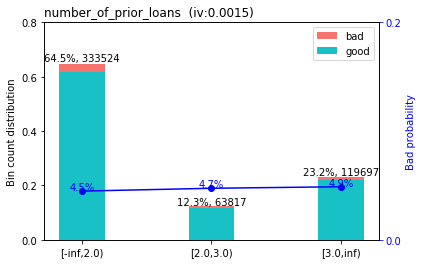

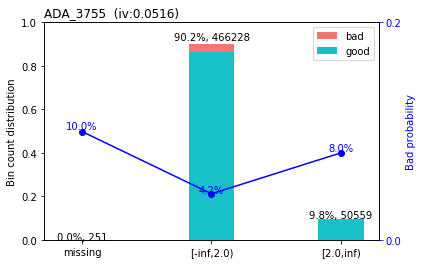

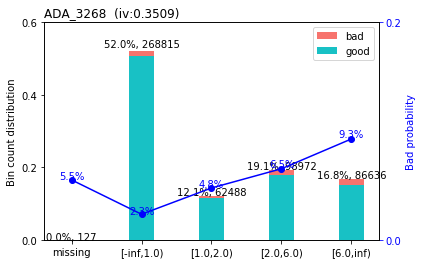

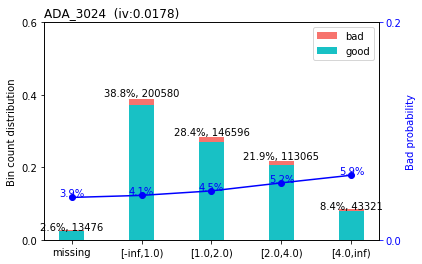

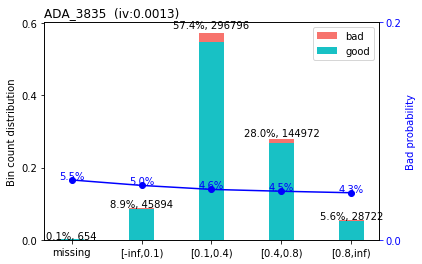

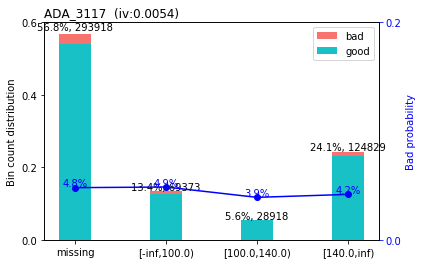

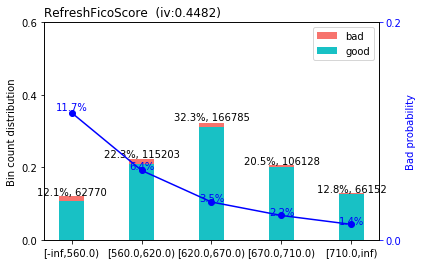

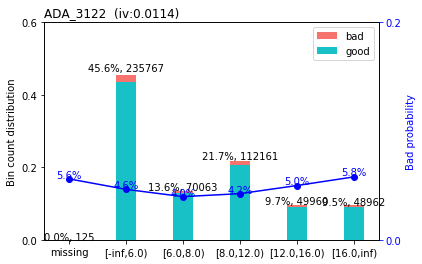

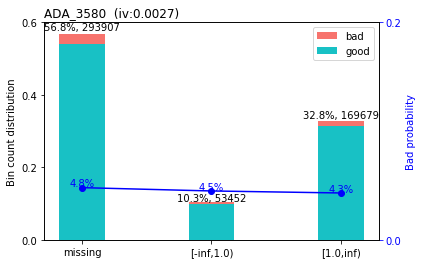

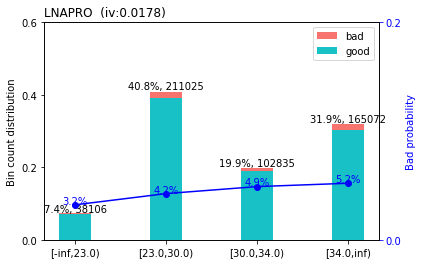

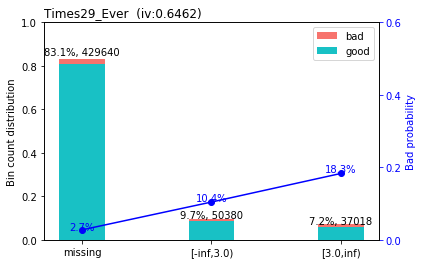

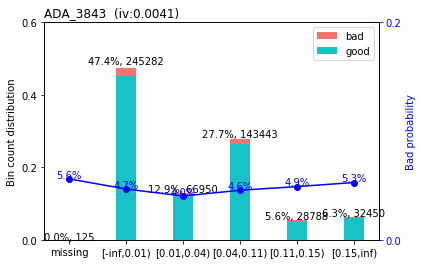

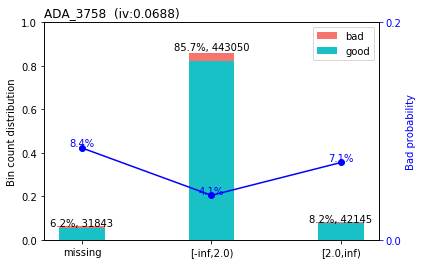

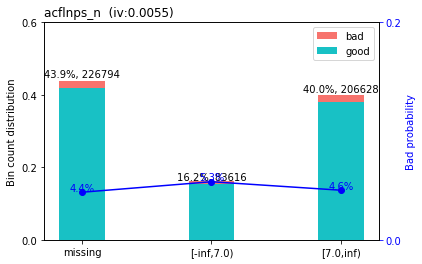

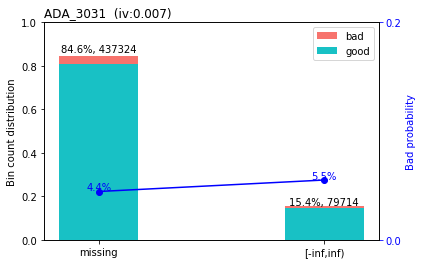

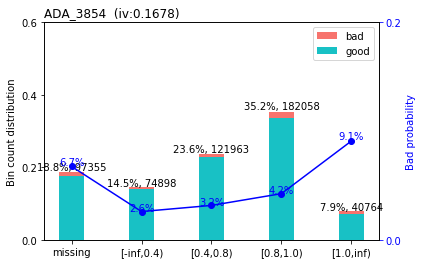

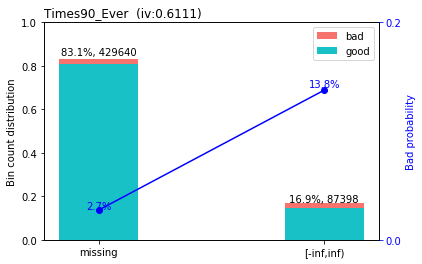

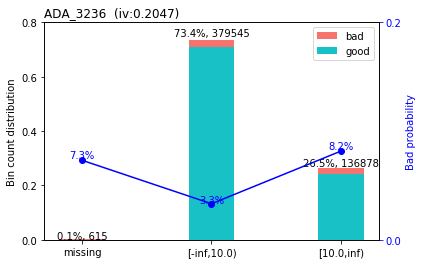

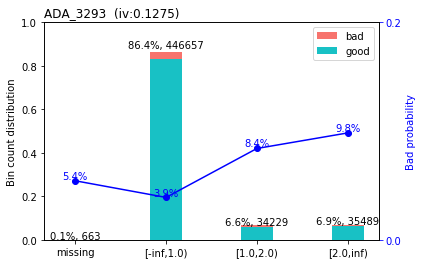

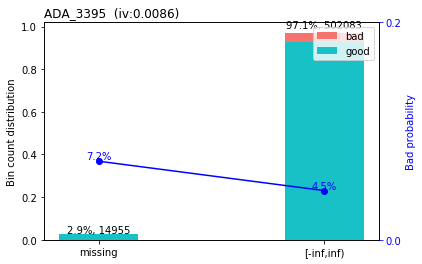

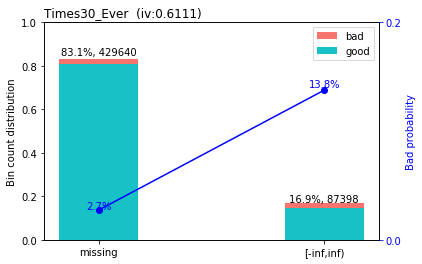

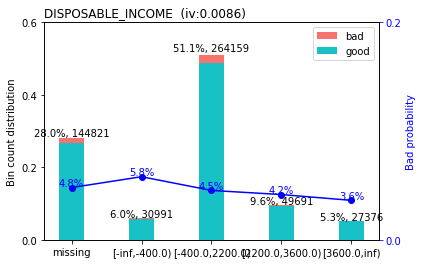

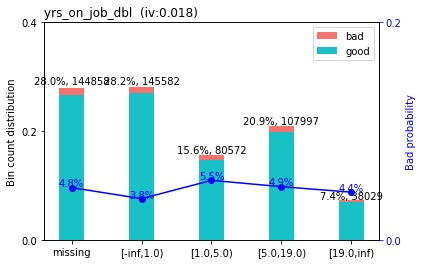

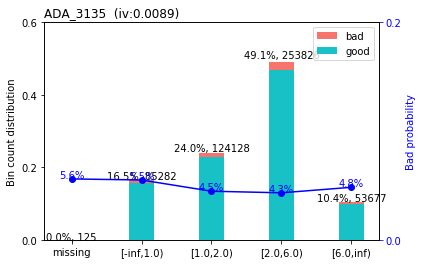

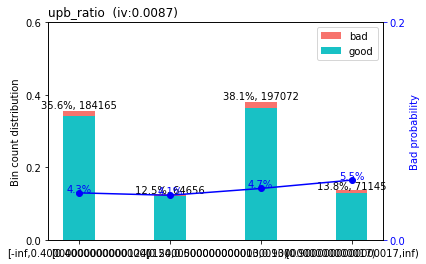

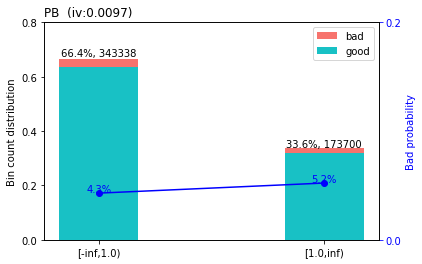

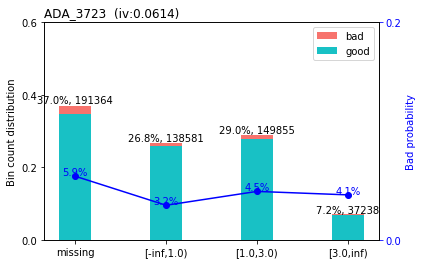

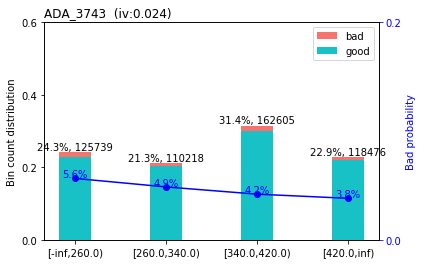

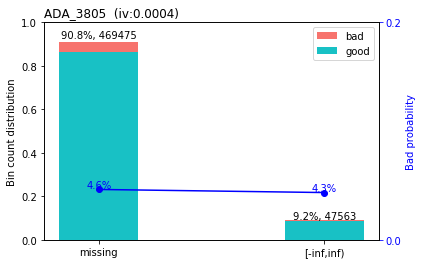

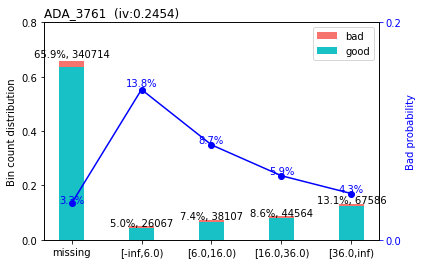

In [9]:
plotlist=sc.woebin_plot(bins)

In [ ]:
for key,i in plotlist.items():
#     plt.show(i)
    i.savefig(str(key)+'.png')

In [9]:
ptable = pd.DataFrame()
for col in df.columns:
    percentiles = df[col].quantile([0.01,0.99]).values
    df.loc[df[col] <= percentiles[0], col] = percentiles[0]
    df.loc[df[col] >= percentiles[1], col] = percentiles[1]
    ptable[col]=percentiles
    

In [10]:
df=df.fillna(0)



In [11]:
#split the model development sample into train and test sample
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(df.drop(['badflag'], axis='columns'), df.badflag, test_size=0.3)

In [12]:
#check VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X=add_constant(X_train)
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index= X.columns)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


const                       414.963660
RefreshFicoScore              2.402792
Original_Term                 1.360381
LNAPRO                        1.491056
number_of_prior_loans         1.697542
DISPOSABLE_INCOME             1.399342
yrs_on_job_dbl                1.203878
__of_days_until_pmt_date      1.180255
MaxCarValue                   1.208355
Times29_Ever                  1.351243
Times30_Ever                  1.772592
Times90_Ever                  1.552510
ADA_3236                      1.285529
ADA_3117                      1.595216
ADA_3113                      1.536218
ADA_3124                      1.439806
ADA_3756                      1.413234
ADA_3854                      2.018195
ADA_3122                      1.946678
ADA_3135                      1.913449
ADA_3159                      3.474212
ADA_3268                      2.273935
ADA_3415                      1.467555
ADA_3743                      1.227281
ADA_3755                      1.549129
ADA_3798                 

In [14]:
from xgboost import XGBClassifier

XGB=XGBClassifier(n_estimators=300, min_samples_leaf=5, class_weight="balanced_subsample", randomstate=42)
XGB.fit(X_train, y_train)

XGB.score(X_test,y_test)

0.9538286981523744

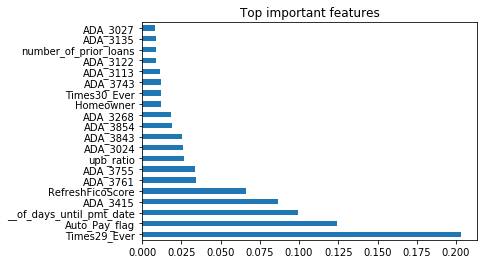

In [15]:
#rank order the variable importance
feat_importances=pd.Series(XGB.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.title('Top important features')
plt.show()

In [16]:
df_feat=pd.DataFrame(data=feat_importances)
df_feat.to_excel('feat_importance_xgb_slows.xlsx')

In [116]:
#feat_importances.nlargest(20).index
X_test.columns

Index(['RefreshFicoScore', 'Original_Term', 'LNAPRO', 'number_of_prior_loans',
       'DISPOSABLE_INCOME', 'yrs_on_job_dbl', '__of_days_until_pmt_date',
       'MaxCarValue', 'Times29_Ever', 'Times30_Ever', 'Times90_Ever',
       'ADA_3236', 'ADA_3117', 'ADA_3113', 'ADA_3124', 'ADA_3756', 'ADA_3854',
       'ADA_3122', 'ADA_3135', 'ADA_3159', 'ADA_3268', 'ADA_3415', 'ADA_3743',
       'ADA_3755', 'ADA_3798', 'ADA_3805', 'ADA_3843', 'ADA_3206', 'ADA_3293',
       'ADA_3761', 'ADA_3835', 'ADA_3024', 'ADA_3027', 'ADA_3031', 'ADA_3580',
       'ADA_3723', 'ADA_3395', 'ADA_3724', 'ADA_3758', 'ADA_3166', 'Homeowner',
       'Auto_Pay_flag', 'PB', 'Coborrower', 'acflnps_n', 'lendingtree',
       'CreditKumar', 'upb_ratio'],
      dtype='object')

In [27]:
#output the probability of being bad;

test_pred=XGB.predict_proba(X_test)[:, 1]
test_pred

array([0.03907165, 0.01380443, 0.12110803, ..., 0.11480889, 0.04699662,
       0.00749948], dtype=float32)

In [28]:
#run the validation on test data
import pandas as pd

#merge only the test dataset
y_test_hat=test_pred
# y_test_hat
#convert ndarray to a dataframe, so that it can merge with true y in the merge statement

y_test_hat_df=pd.DataFrame(data=y_test_hat, columns=['Y_hats'], index=X_test.index.copy())

df_out=pd.merge(y_test, y_test_hat_df, how='left', left_index=True, right_index=True)
ks_test=ks(data=df_out, target='badflag', prob='Y_hats')


      min_score    max_score  events  nonevents     total event_rate  \
0      0.129841      0.82379  3551.0    11961.0   15512.0     22.89%   
1     0.0650549     0.129841  1455.0    14057.0   15512.0      9.38%   
2     0.0390384    0.0650509   812.0    14700.0   15512.0      5.23%   
3     0.0261249    0.0390383   510.0    15001.0   15511.0      3.29%   
4      0.018285    0.0261239   324.0    15188.0   15512.0      2.09%   
5     0.0129109    0.0182849   210.0    15302.0   15512.0      1.35%   
6    0.00738158    0.0129109   137.0    15374.0   15511.0      0.88%   
7    0.00186659    0.0073812    53.0    15459.0   15512.0      0.34%   
8   0.000478672   0.00186638     4.0    15508.0   15512.0      0.03%   
9   4.31346e-05  0.000478606     1.0    15511.0   15512.0      0.01%   
10                            7057.0   148061.0  155118.0      4.55%   

   nonevent_rate % events % nonevents % cum_events % cum_nonevents    KS  
0         77.11%   50.32%       8.08%       50.32%          

AUC is 0.8574


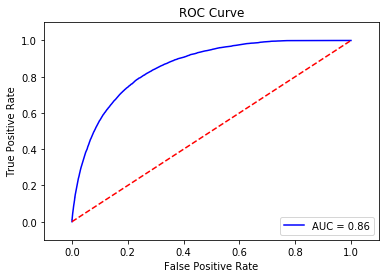

In [29]:
y_pred=np.round(y_test_hat,4)

from sklearn import metrics

auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
print('AUC is ' + repr(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [40]:
def gini(actual, pred):
    assert (len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)


def gini_normalized(actual, pred):
    return gini(actual, pred) / gini(actual, actual)


In [33]:
gini_predictions =gini(y_test, y_pred)
gini_max = gini(y_test, y_pred)
ngini= gini_normalized(y_test, y_pred)
print('Normalized Gini: %.3f' % (ngini))

Normalized Gini: 0.715


In [30]:
df1=pd.read_csv('s3://mf-ml-ds/propensity_to_pay/Monthly_Validation/val_202011/slows.csv')

df1.head()



,RefreshFicoScore,Original_Term,LNAPRO,number_of_prior_loans,DISPOSABLE_INCOME,yrs_on_job_dbl,__of_days_until_pmt_date,MaxCarValue,Times29_Ever,Times30_Ever,Times90_Ever,ADA_3236,ADA_3117,ADA_3113,ADA_3124,ADA_3756,ADA_3854,ADA_3122,ADA_3135,ADA_3159,ADA_3268,ADA_3415,ADA_3743,ADA_3755,ADA_3798,ADA_3805,ADA_3843,ADA_3206,ADA_3293,ADA_3761,ADA_3835,ADA_3024,ADA_3027,ADA_3031,ADA_3580,ADA_3723,ADA_3395,ADA_3724,ADA_3758,ADA_3166,badflag,Homeowner,FPD_n,Auto_Pay_flag,PB,Coborrower,acflnps_n,lendingtree,CreditKumar,upb_ratio
0,775,120,16.99000,0,1281.92,11.03,-17,NaN,NaN,NaN,NaN,0.0,166.0,165.0,55.0,1.0,0.2532,19.0,0.0,33973.0,0.0,0.0,287,1.0,NaN,NaN,0.0000,110668.0,0.0,NaN,0.5000,NaN,NaN,NaN,1.0,0.0,0.0,0.0,1.0,7552.0,0,1,0.0,0,0,1,NaN,0,0,0.839389
1,781,28,35.98791,0,1633.61,5.19,-51,NaN,NaN,NaN,NaN,0.0,NaN,229.0,20.0,1.0,0.2656,15.0,0.0,2180.0,0.0,0.0,351,1.0,NaN,NaN,0.0000,3150.0,0.0,NaN,1.0000,0.0,0.0,NaN,NaN,0.0,0.0,0.0,1.0,1794.0,0,0,0.0,0,0,0,7.0,0,0,0.477165
2,610,36,35.98876,1,1812.44,3.00,-77,NaN,9.0,0.0,0.0,6108.0,38.0,40.0,30.0,10.0,0.0000,2.0,1.0,1692.0,10.0,0.0,248,1.0,NaN,NaN,0.1250,144786.0,0.0,NaN,0.5000,0.0,0.0,NaN,1.0,NaN,0.0,0.0,1.0,1692.0,0,1,0.0,0,1,0,7.0,0,0,0.364811
3,669,42,35.98793,1,154.64,0.00,-3,NaN,NaN,NaN,NaN,0.0,NaN,96.0,15.0,1.0,0.7322,15.0,0.0,10735.0,0.0,0.0,364,1.0,NaN,NaN,0.0000,3141.0,0.0,NaN,0.5000,0.0,0.0,NaN,NaN,1.0,0.0,7.0,1.0,1910.0,0,0,0.0,0,0,0,NaN,0,0,0.583632
4,588,30,35.98663,7,2383.49,16.15,-2,NaN,NaN,NaN,NaN,118.0,280.0,NaN,NaN,NaN,NaN,2.0,6.0,18561.0,5.0,1.0,444,1.0,905.0,NaN,0.0667,88522.0,0.0,3.0,0.1892,4.0,2.0,NaN,1.0,1.0,0.0,2.0,1.0,6874.0,0,1,0.0,0,1,1,7.0,0,0,0.166682


In [31]:
X_oot1=df1[X_train.columns]
X_oot1.columns
y_test=df1.loc[: ,'badflag']

In [37]:
def impute_slows(df, ptable):
    for col in df.columns:
        p1 = ptable[col].min()
        p99= ptable[col].max()
    
        df.loc[df[col] <= p1, col] = p1
        df.loc[df[col] >= p99, col] = p99

In [32]:
impute_slows(X_oot1, ptable)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [33]:
X_oot1=X_oot1.fillna(0)


In [34]:
test_pred=XGB.predict_proba(X_oot1)[:, 1]
#merge only the test dataset
y_test_hat=test_pred

#convert ndarray to a dataframe, so that it can merge with true y in the merge statement

y_test_hat_df=pd.DataFrame(data=y_test_hat, columns=['Y_hats'], index=X_oot1.index.copy())

df_out=pd.merge(y_test, y_test_hat_df, how='left', left_index=True, right_index=True)
ks_test=ks(data=df_out, target='badflag', prob='Y_hats')


      min_score    max_score  events  nonevents   total event_rate  \
0      0.133721     0.818058   11562      40881   52443     22.05%   
1     0.0700222     0.133719    5080      47363   52443      9.69%   
2     0.0409095    0.0700221    2880      49562   52442      5.49%   
3      0.026983    0.0409094    1775      50668   52443      3.38%   
4     0.0185181    0.0269829    1257      51185   52442      2.40%   
5     0.0126579     0.018518     915      51528   52443      1.74%   
6    0.00695109    0.0126579     625      51817   52442      1.19%   
7    0.00247349   0.00695093     220      52223   52443      0.42%   
8   0.000648981   0.00247346      92      52351   52443      0.18%   
9   6.10677e-05  0.000648969      10      52433   52443      0.02%   
10                             24416     500011  524427      4.66%   

   nonevent_rate % events % nonevents % cum_events % cum_nonevents    KS  
0         77.95%   47.35%       8.18%       47.35%           8.18%  39.2  
1        

In [35]:
df2=pd.read_csv('s3://mf-ml-ds/propensity_to_pay/Monthly_Validation/val_202012/slows.csv')

df2.head()

,RefreshFicoScore,Original_Term,LNAPRO,number_of_prior_loans,DISPOSABLE_INCOME,yrs_on_job_dbl,__of_days_until_pmt_date,MaxCarValue,Times29_Ever,Times30_Ever,Times90_Ever,ADA_3236,ADA_3117,ADA_3113,ADA_3124,ADA_3756,ADA_3854,ADA_3122,ADA_3135,ADA_3159,ADA_3268,ADA_3415,ADA_3743,ADA_3755,ADA_3798,ADA_3805,ADA_3843,ADA_3206,ADA_3293,ADA_3761,ADA_3835,ADA_3024,ADA_3027,ADA_3031,ADA_3580,ADA_3723,ADA_3395,ADA_3724,ADA_3758,ADA_3166,badflag,Homeowner,FPD_n,Auto_Pay_flag,PB,Coborrower,acflnps_n,lendingtree,CreditKumar,upb_ratio
0,658,72,15.99000,0,1146.57,5.07,-12,NaN,2.0,0.0,0.0,6776.0,54.0,88.0,78.0,60.0,NaN,6.0,1.0,20163.0,4.0,0.0,386,0.0,NaN,0.0,0.0714,268100.0,0.0,NaN,0.5000,2.0,1.0,1.0,1.0,NaN,0.0,NaN,60.0,3485.0,0,1,0.0,0,0,0,NaN,0,0,0.675654
1,471,48,35.98666,0,2819.21,3.03,-21,NaN,4.0,0.0,0.0,133.0,NaN,27.0,11.0,NaN,1.3071,3.0,4.0,46826.0,5.0,1.0,55,1.0,NaN,NaN,0.1000,51221.0,0.0,NaN,0.5714,4.0,2.0,NaN,NaN,NaN,0.0,2.0,20.0,4124.0,1,0,0.0,0,0,1,7.0,0,0,0.941386
2,559,42,29.99000,0,742.47,1.15,-9,2375.0,NaN,NaN,NaN,2611.0,58.0,61.0,2.0,0.0,0.4785,1.0,8.0,10593.0,1.0,0.0,319,0.0,131.0,NaN,0.2609,168055.0,0.0,42.0,0.6667,6.0,3.0,NaN,1.0,0.0,0.0,3.0,0.0,4866.0,0,1,0.0,1,0,0,1.0,0,0,0.912296
3,634,24,35.98471,1,163.37,2.45,-5,NaN,NaN,NaN,NaN,0.0,NaN,122.0,122.0,0.0,0.8332,12.0,1.0,3343.0,0.0,0.0,443,0.0,NaN,NaN,0.0000,1765.0,0.0,49.0,0.0909,0.0,0.0,NaN,NaN,NaN,0.0,1.0,0.0,1135.0,0,0,0.0,0,0,0,7.0,0,0,0.238163
4,654,48,28.09692,2,1397.08,7.58,-6,3850.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,5177.0,2.0,0.0,138,0.0,NaN,NaN,0.1429,5389.0,0.0,29.0,0.1667,2.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,5177.0,0,0,0.0,0,1,0,1.0,0,0,0.548835


In [36]:
X_oot1=df2[X_train.columns]
X_oot1.columns
y_test=df2.loc[: ,'badflag']

In [37]:
impute_slows(X_oot1, ptable)
X_oot1=X_oot1.fillna(0)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [38]:
test_pred=XGB.predict_proba(X_oot1)[:, 1]
#merge only the test dataset
y_test_hat=test_pred

#convert ndarray to a dataframe, so that it can merge with true y in the merge statement

y_test_hat_df=pd.DataFrame(data=y_test_hat, columns=['Y_hats'], index=X_oot1.index.copy())

df_out=pd.merge(y_test, y_test_hat_df, how='left', left_index=True, right_index=True)
ks_test=ks(data=df_out, target='badflag', prob='Y_hats')


      min_score    max_score  events  nonevents   total event_rate  \
0      0.134369     0.833135   12275      41821   54096     22.69%   
1     0.0701649     0.134368    4425      49670   54095      8.18%   
2     0.0423422    0.0701642    2477      51619   54096      4.58%   
3     0.0279392    0.0423421    1495      52600   54095      2.76%   
4     0.0191767     0.027939    1087      53009   54096      2.01%   
5     0.0128942    0.0191765     726      53369   54095      1.34%   
6    0.00686525    0.0128941     493      53603   54096      0.91%   
7    0.00179144   0.00686507     208      53887   54095      0.38%   
8   0.000562562   0.00179135     109      53987   54096      0.20%   
9   5.85865e-05  0.000562552      33      54063   54096      0.06%   
10                             23328     517628  540956      4.31%   

   nonevent_rate % events % nonevents % cum_events % cum_nonevents    KS  
0         77.31%   52.62%       8.08%       52.62%           8.08%  44.5  
1        

In [34]:
df3=pd.read_csv('s3://mf-ml-ds/propensity_to_pay/Monthly_Validation/val_202103/slows.csv')

df3.head()

,RefreshFicoScore,Original_Term,LNAPRO,number_of_prior_loans,DISPOSABLE_INCOME,yrs_on_job_dbl,__of_days_until_pmt_date,MaxCarValue,Times29_Ever,Times30_Ever,Times90_Ever,ADA_3236,ADA_3117,ADA_3113,ADA_3124,ADA_3756,ADA_3854,ADA_3122,ADA_3135,ADA_3159,ADA_3268,ADA_3415,ADA_3743,ADA_3755,ADA_3798,ADA_3805,ADA_3843,ADA_3206,ADA_3293,ADA_3761,ADA_3835,ADA_3024,ADA_3027,ADA_3031,ADA_3580,ADA_3723,ADA_3395,ADA_3724,ADA_3758,ADA_3166,badflag,Homeowner,FPD_n,Auto_Pay_flag,PB,Coborrower,acflnps_n,lendingtree,CreditKumar,upb_ratio
0,683,30,31.55294,6,305.40,6.79,-47,1425.0,NaN,NaN,NaN,0.0,NaN,120.0,17.0,0.0,0.8682,1.0,1.0,94713.0,0.0,0.0,302,0.0,NaN,NaN,0.0323,67627.0,0.0,NaN,0.1176,0.0,0.0,NaN,NaN,1.0,0.0,7.0,0.0,73058.0,0.0,0,0.0,0,1,0,1.0,0,0,0.083975
1,680,41,26.66362,0,-286.41,2.08,-3,NaN,NaN,NaN,NaN,0.0,NaN,68.0,32.0,0.0,0.9312,14.0,0.0,30431.0,0.0,0.0,376,0.0,NaN,NaN,0.0000,30353.0,0.0,NaN,0.8000,0.0,0.0,NaN,NaN,3.0,0.0,5.0,0.0,14393.0,0.0,0,0.0,1,0,0,7.0,0,0,0.196662
2,644,42,29.11775,2,97.39,0.00,-31,NaN,NaN,NaN,NaN,206.0,NaN,172.0,12.0,0.0,0.8363,5.0,2.0,24492.0,0.0,0.0,314,0.0,NaN,NaN,0.0500,18346.0,0.0,NaN,0.2500,0.0,0.0,NaN,NaN,NaN,0.0,2.0,0.0,257.0,0.0,0,0.0,0,0,0,7.0,0,0,-0.314328
3,719,24,35.98195,2,1732.66,0.00,-76,NaN,1.0,0.0,0.0,0.0,NaN,396.0,80.0,0.0,0.6561,18.0,0.0,9451.0,0.0,0.0,540,0.0,NaN,NaN,0.0000,2103.0,0.0,NaN,0.0909,0.0,0.0,NaN,NaN,1.0,0.0,5.0,0.0,1674.0,0.0,1,0.0,0,1,0,7.0,0,0,-0.114695
4,667,18,35.98875,0,771.24,0.00,-5,NaN,NaN,NaN,NaN,0.0,159.0,NaN,NaN,NaN,NaN,18.0,0.0,10486.0,7.0,2.0,354,0.0,63.0,NaN,0.0000,96527.0,0.0,NaN,0.4286,1.0,1.0,NaN,2.0,NaN,0.0,NaN,141.0,230.0,0.0,1,0.0,0,0,0,7.0,0,0,-0.191303


In [35]:
X_oot1=df3[X_train.columns]

y_test=df3.loc[: ,'badflag']

In [38]:
impute_slows(X_oot1, ptable)
X_oot1=X_oot1.fillna(0)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [39]:
test_pred=XGB.predict_proba(X_oot1)[:, 1]
#merge only the test dataset
y_test_hat=test_pred

#convert ndarray to a dataframe, so that it can merge with true y in the merge statement

y_test_hat_df=pd.DataFrame(data=y_test_hat, columns=['Y_hats'], index=X_oot1.index.copy())

df_out=pd.merge(y_test, y_test_hat_df, how='left', left_index=True, right_index=True)
ks_test=ks(data=df_out, target='badflag', prob='Y_hats')

      min_score    max_score   events  nonevents     total event_rate  \
0      0.145718     0.888005  12878.0    41555.0   54433.0     23.66%   
1     0.0708062     0.145714   4031.0    50401.0   54432.0      7.41%   
2     0.0406889    0.0708059   1955.0    52477.0   54432.0      3.59%   
3        0.0262    0.0406888   1185.0    53247.0   54432.0      2.18%   
4     0.0178729       0.0262    744.0    53688.0   54432.0      1.37%   
5     0.0121012    0.0178729    526.0    53907.0   54433.0      0.97%   
6    0.00658924     0.012101    329.0    54103.0   54432.0      0.60%   
7    0.00207991    0.0065892    107.0    54325.0   54432.0      0.20%   
8   0.000517427   0.00207986     21.0    54411.0   54432.0      0.04%   
9   2.61681e-05  0.000517405      2.0    54430.0   54432.0      0.00%   
10                            21778.0   522544.0  544322.0      4.00%   

   nonevent_rate % events % nonevents % cum_events % cum_nonevents    KS  
0         76.34%   59.13%       7.95%       59.1

In [41]:
ngini= gini_normalized(y_test, y_test_hat)
print('Normalized Gini: %.3f' % (ngini))

Normalized Gini: nan


In [67]:
ks_test.to_excel('slows_ks_xgb_all.xlsx')

In [59]:
upload_model(XGB, 'slows_xgb_model_all')